In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [3]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 10 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
total_weeks = 10

stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params)
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/10_weeks/demand_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/10_weeks/supply_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


In [4]:
weekly_sim_log_df = pd.read_json("../data/10_weeks/logfile_matched_trips_week_0_.log", lines=True)

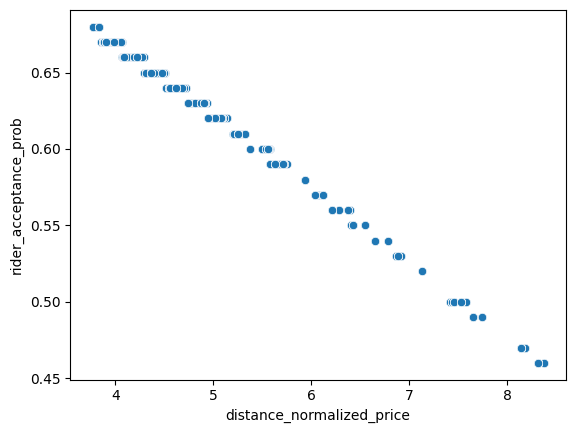

In [5]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [7]:
weekly_sim_log_df.shape

(1863, 12)

In [8]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

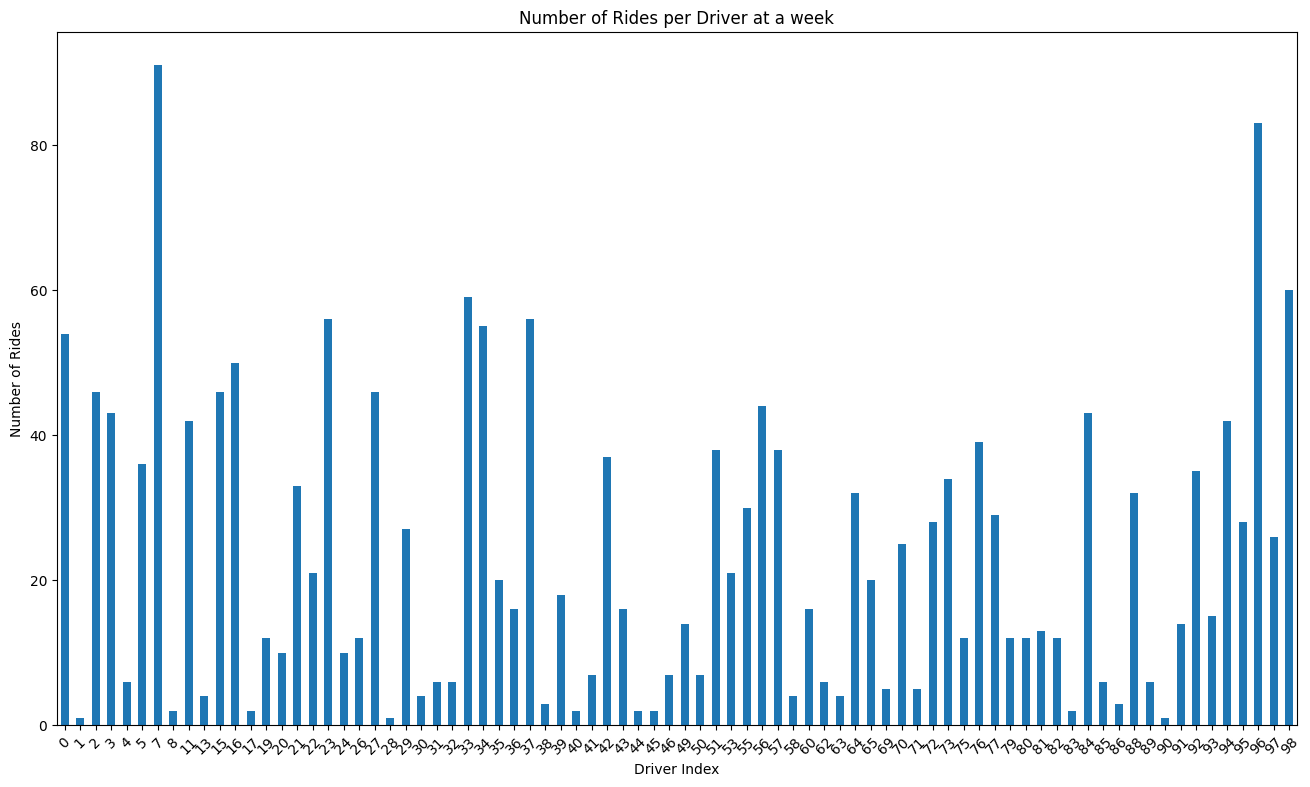

In [9]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 24.2 riders per week

In [10]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

23.2875

In [7]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.580080515297907, 0.6413365539452496)

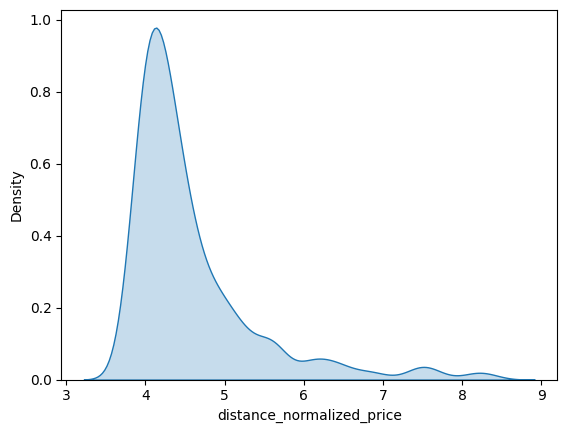

In [6]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

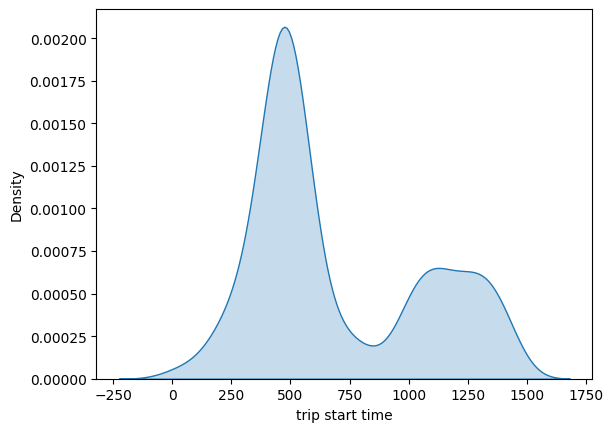

In [12]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

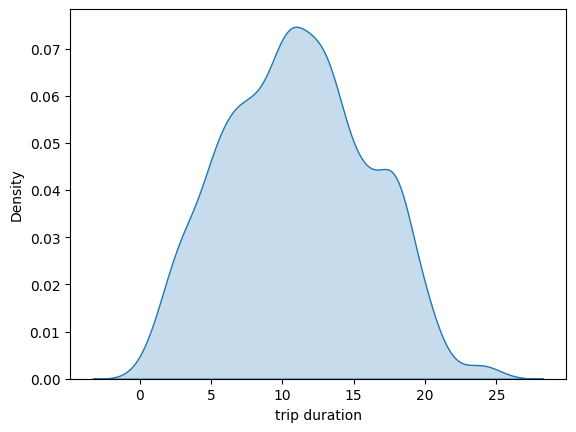

In [13]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

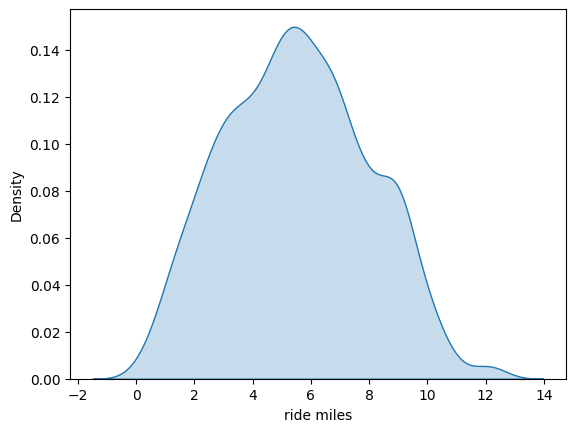

In [14]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

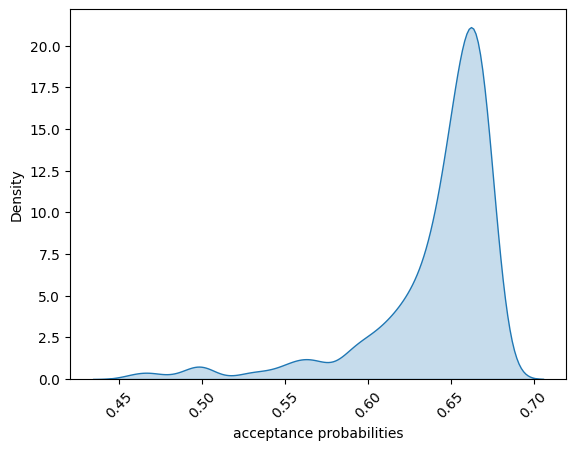

In [15]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

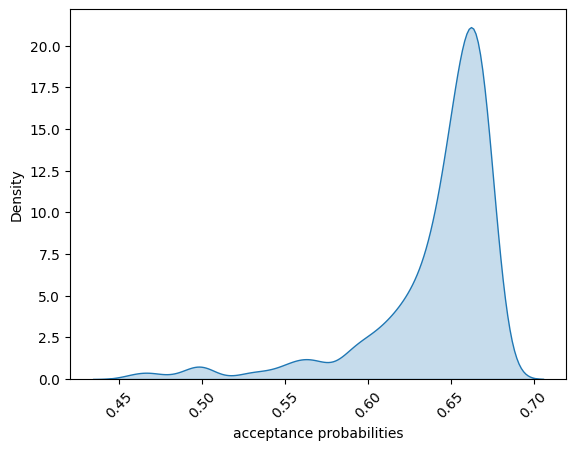

In [16]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [22]:
#data_folder = r'../data/10_weeks'
daily_avg_price_lst, daily_total_requests = [], []
for i in range(10):
    trips_df = pd.read_json('../data/10_weeks/logfile_matched_trips_week_'+str(i)+'_.log', lines=True)
    requests_df = pd.read_json('../data/10_weeks/demand_week_'+str(i)+'.json')
    daily_avg_price_lst.append(trips_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [23]:
daily_avg_price_lst, daily_total_requests

([23.653853998926465,
  23.19174712643678,
  23.131691542288557,
  24.206345821325645,
  24.24813226744186,
  22.99094027954257,
  24.413079112122936,
  23.6937,
  23.43260193133047,
  23.37940170940171],
 [1051, 1091, 1010, 957, 996, 1033, 1009, 995, 1024, 1058])

In [24]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [32]:
long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [34]:
long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [35]:
long_term_rider_elasticity_df

,daily_avg_price,daily_total_requests,daily_avg_price_change,daily_total_requests_change
0,23.653854,1051,NaN,NaN
1,23.191747,1091,-0.019536,0.038059
2,23.131692,1010,-0.002590,-0.074244
3,24.206346,957,0.046458,-0.052475
4,24.248132,996,0.001726,0.040752
5,22.990940,1033,-0.051847,0.037149
6,24.413079,1009,0.061856,-0.023233
7,23.693700,995,-0.029467,-0.013875
8,23.432602,1024,-0.011020,0.029146
9,23.379402,1058,-0.002270,0.033203


In [39]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(23.634149378881702, 1022.4)

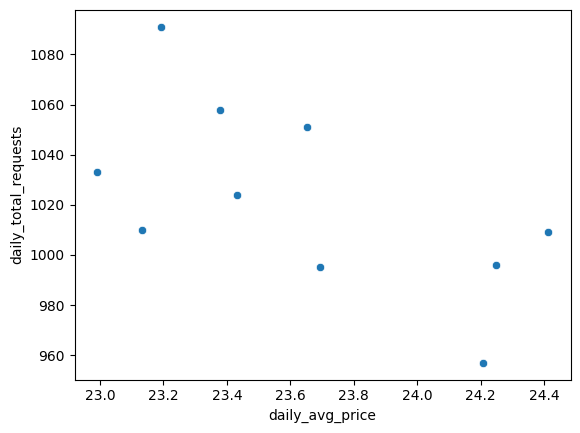

In [29]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.show()

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-46.20628289606067,
 2114.4461922083647,
 -0.6130943030533758,
 0.0594531743201879,
 21.05044104637041)

### roughly 4.3%(i.e. 1 / 23) increase of ride price will cause a drop of 4.5%(i.e. 46/1022) for the next day's requests

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-46.20628289606067,
 2114.4461922083647,
 -0.6130943030533758,
 0.0594531743201879,
 21.05044104637041)

### as below, the ride share company makes $7.1 per ride

In [17]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(23.65, 44067.130000000005)

In [18]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

7.1